# Job Schedule Visualization
This notebook is used to calculate the job schedules of each algorithm on a single instance of job data and plot those schedules for comparison. In this case, the peak demand above the curve (PDAC) is not the primary area of focus. Instead, we are looking at how the algorithms are able to move the jobs around to create the most efficient schedule possible with the given constraints. 

In [60]:
import sys
import os
import random
import json
import matplotlib.pyplot as plt
import numpy as np

# Add the parent directory of AAC/ to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

Import the necessary algorithm functions from their respective files in the directory

In [61]:
from PDAC.pdac_scheduling_ilp import solve_pdac_ilp
from PDAC.pdac_scheduling_lp import solve_pdac_lp
from PDAC.pdac_scheduling_greedy import solve_pdac_greedy
from PDAC.pdac_scheduling_naive import solve_pdac_naive

# Program Parameters
In the code below, you can specify the start time, end time and maximum length of each job in each batch of jobs. \
\
&emsp;&emsp; - 0 denotes 12am and 1400 denotes 12am of the following day. \
&emsp;&emsp; - Therefore, one day contains exactly 1440 minutes of job data
\
\
Additionally, you can specify the size of the job batch that is analyzed in this program. \
\
\
For the exact algorithm, because it is an ILP, runtime increases exponentially as the job batch sizes increase. It is therefore advisable to keep the job batch sizes at or below 100 for this analysis

In [62]:
start_time = 0
end_time = 1440
max_length = 700

batch_size = 800

analysis_num = 0

# Resource Curve
The resource curve is represented by a list of values across the specified time period. Where at a given time t there will be exactly resources[t] amount of power available to the jobs. The data for these resources is available in the Input_Data folder. 
\
\
Additionally, each height is multiplied by a scaling factor. This is so that the resource curve better fits the job curve. Otherwise, the resource curve would be too large for any sort of significant analysis. This scaling factor remains constant for each of the trials and for every job batch size for the sake of consistency. 

In [63]:
# Instantiate the resource curve
path = '../../Input_Data/resource_data.json'
with open(path, 'r') as file:
    data = json.load(file)

wind_energy = data['series'][1]['data']
solar_energy = data['series'][2]['data']
hydro_energy = data['series'][3]['data']

# Have 165 hours and you want minute by minute resolution. Therefore the total length of this list needs to be 165 * 60 in length
# The first 60 values of the list need to equal 0, the next need to equal 1. Therefore, i // 60
wind_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(wind_energy_7_days)):
    wind_energy_7_days[i] = wind_energy[ i // 60 ]['value']

solar_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(solar_energy_7_days)):
    solar_energy_7_days[i] = solar_energy[ i // 60 ]['value']

hydro_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(hydro_energy_7_days)):
    hydro_energy_7_days[i] = hydro_energy[ i // 60 ]['value']


total = []
for i in range(165 * 60):
    total_sum = wind_energy_7_days[i] + solar_energy_7_days[i] + hydro_energy_7_days[i]
    total.append(total_sum)

day = 2
# resources = total[(24 * day) + start_time : (24 * day) + end_time]
resources = solar_energy_7_days[(24 * day) + start_time : (24 * day) + end_time]

# Implement a resource curve scaling factor to better fit the jobs
scale_factor = 200
resources = [r * scale_factor for r in resources]

# Calculate the Job Schedules
Use the algorithms and the caluclate job schedules

In [64]:
# This is The list of job objects that will be scheduled
# They each have a release, deadline, duration and height
path = '../../Input_Data/job_data.json'
with open(path, 'r') as file:
    data = json.load(file)

# Randomly shuffle the jobs so that there is variation between trials
jobs_array = data['jobs']
random.shuffle(jobs_array)
        
# exact_intervals = solve_pdac_ilp(jobs_array, resources, start_time, end_time, max_length, batch_size)[1]

inexact_intervals = solve_pdac_lp(jobs_array, resources, start_time, end_time, max_length, batch_size)[1]

greedy_intervals = solve_pdac_greedy(jobs_array, resources, start_time, end_time, max_length, batch_size)[1]

naive_intervals = solve_pdac_naive(jobs_array, resources, start_time, end_time, max_length, batch_size)[1]

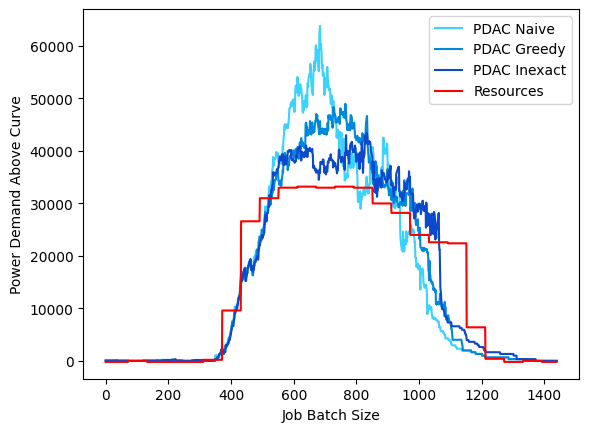

In [69]:
job_graph_xvalues = np.array([i for i in range(start_time, end_time)])

# plt.plot(job_graph_xvalues, exact_intervals, label="PDAC Exact", color='blue')
plt.plot(job_graph_xvalues, naive_intervals, label="PDAC Naive", color='#3AD2FF')
plt.plot(job_graph_xvalues, greedy_intervals, label="PDAC Greedy", color='#0088DD')
plt.plot(job_graph_xvalues, inexact_intervals, label="PDAC Inexact", color='#0D49CD')


plt.plot(job_graph_xvalues, resources, label="Resources", color='red')


plt.xlabel("Job Batch Size")
plt.ylabel("Power Demand Above Curve")
plt.legend()
plt.show()